In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [2]:
datasetPath='..\kvasir-dataset'
categories=[
    'dyed-lifted-polyps', 
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]
EPOCHS = 25
Learing_Rate = 1e-3
Batch_Size = 32

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

In [4]:
data = []
labels = []

print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(datasetPath)))
random.seed(42)
random.shuffle(imagePaths)

printProgressBar(0, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)
for i,imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    label = categories.index(label)
    labels.append(label)
    printProgressBar(i + 1, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)

print("[INFO] loading images completed...")

[INFO] loading images...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[INFO] loading images completed...


In [5]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

trainY = to_categorical(trainY, num_classes=8)
testY = to_categorical(testY, num_classes=8)

In [6]:
print ("number of training examples = " + str(trainX.shape[0]))
print ("number of test examples = " + str(testX.shape[0]))
print ("X_train shape: " + str(trainX.shape))
print ("Y_train shape: " + str(trainY.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test shape: " + str(testY.shape))

number of training examples = 3000
number of test examples = 1000
X_train shape: (3000, 96, 96, 3)
Y_train shape: (3000, 8)
X_test shape: (1000, 96, 96, 3)
Y_test shape: (1000, 8)


In [7]:
generator = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [16]:
def buildModel(width, height, depth, classes):
    inputShape = (height, width, depth)
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
    base_model = MobileNet(
        input_shape=inputShape,
        include_top=False,
        weights='imagenet'
    )
    inputs = tf.keras.layers.Input([height, width, 3], dtype = tf.float32)
    model = tf.keras.applications.mobilenet.preprocess_input(inputs)
    base_model.trainable = True
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    model = base_model(model)
    model = GlobalAveragePooling2D()(model)
    model = Dense(1024,activation='relu')(model)
    model = Dropout(0.2)(model)
    model = Dense(512,activation='relu')(model)
    model = Dense(classes,activation='softmax')(model)
    model = Model(inputs = inputs, outputs = model)
    return model

In [17]:
print("[INFO] compiling model...")
model = buildModel(width=96, height=96, depth=3, classes=8)
model.summary()

[INFO] compiling model...
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)         

In [18]:
opt = Adam(lr=Learing_Rate, decay=Learing_Rate / EPOCHS)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt, 
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.SpecificityAtSensitivity(0.5,name="specificity")
    ]
)
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
          print("\nReached 95.0% accuracy so cancelling training!")
          self.model.stop_training = True
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15, restore_best_weights=True)

checkpoint = ModelCheckpoint('Model_MobileNet_2.model', monitor="val_loss", 
                        verbose=1, save_best_only=True, mode="min")
callbacks = myCallback()


In [19]:
print("[INFO] training network...")
history = model.fit(
    x=generator.flow(trainX, trainY, batch_size=Batch_Size),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX) // Batch_Size,
    epochs=100, 
    verbose=1,
    callbacks = [checkpoint, early, callbacks]
)
print("[INFO] training network completed...")

[INFO] training network...
Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 2.0831 - accuracy: 0.1466 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 0.5441
Epoch 00001: val_loss improved from inf to 2.00676, saving model to Model_MobileNet_2.model
INFO:tensorflow:Assets written to: Model_MobileNet_2.model\assets
93/93 [==============================] - 45s 484ms/step - loss: 2.0831 - accuracy: 0.1466 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 0.5441 - val_loss: 2.0068 - val_accuracy: 0.1910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity: 0.6140
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 1.9140 - accuracy: 0.2257 - precision: 0.3333 - recall: 6.7385e-04 - specificity: 0.6939
Epoch 00002: val_loss improved from 2.00676 to 1.78625, saving model to Model_MobileNet_2.model
INFO:tensorflow:Assets written to: Model_MobileNet_2.model\assets
93/93 [==============================] - 45s 484ms/step

Epoch 17/100
93/93 [==============================] - ETA: 0s - loss: 1.5003 - accuracy: 0.3892 - precision: 0.6166 - recall: 0.1051 - specificity: 0.8862
Epoch 00017: val_loss improved from 1.39663 to 1.36886, saving model to Model_MobileNet_2.model
INFO:tensorflow:Assets written to: Model_MobileNet_2.model\assets
93/93 [==============================] - 43s 459ms/step - loss: 1.5003 - accuracy: 0.3892 - precision: 0.6166 - recall: 0.1051 - specificity: 0.8862 - val_loss: 1.3689 - val_accuracy: 0.4440 - val_precision: 0.6679 - val_recall: 0.1850 - val_specificity: 0.9127
Epoch 18/100
93/93 [==============================] - ETA: 0s - loss: 1.4834 - accuracy: 0.4006 - precision: 0.6208 - recall: 0.1125 - specificity: 0.8937
Epoch 00018: val_loss did not improve from 1.36886
93/93 [==============================] - 27s 292ms/step - loss: 1.4834 - accuracy: 0.4006 - precision: 0.6208 - recall: 0.1125 - specificity: 0.8937 - val_loss: 1.4019 - val_accuracy: 0.4430 - val_precision: 0.6904 

93/93 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.4168 - precision: 0.5928 - recall: 0.1442 - specificity: 0.8938
Epoch 00033: val_loss did not improve from 1.26936
93/93 [==============================] - 26s 283ms/step - loss: 1.4427 - accuracy: 0.4168 - precision: 0.5928 - recall: 0.1442 - specificity: 0.8938 - val_loss: 1.3989 - val_accuracy: 0.4190 - val_precision: 0.5667 - val_recall: 0.2420 - val_specificity: 0.9069
Epoch 34/100
93/93 [==============================] - ETA: 0s - loss: 1.4133 - accuracy: 0.4217 - precision: 0.6213 - recall: 0.1566 - specificity: 0.9016
Epoch 00034: val_loss did not improve from 1.26936
93/93 [==============================] - 26s 283ms/step - loss: 1.4133 - accuracy: 0.4217 - precision: 0.6213 - recall: 0.1566 - specificity: 0.9016 - val_loss: 1.2857 - val_accuracy: 0.4710 - val_precision: 0.6299 - val_recall: 0.2740 - val_specificity: 0.9316
Epoch 35/100
93/93 [==============================] - ETA: 0s - loss: 1.4147 

Epoch 50/100
93/93 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.4528 - precision: 0.6222 - recall: 0.1887 - specificity: 0.9168
Epoch 00050: val_loss did not improve from 1.22777
93/93 [==============================] - 26s 284ms/step - loss: 1.3617 - accuracy: 0.4528 - precision: 0.6222 - recall: 0.1887 - specificity: 0.9168 - val_loss: 1.3076 - val_accuracy: 0.4870 - val_precision: 0.5903 - val_recall: 0.2910 - val_specificity: 0.9313
Epoch 51/100
93/93 [==============================] - ETA: 0s - loss: 1.3626 - accuracy: 0.4377 - precision: 0.6200 - recall: 0.1897 - specificity: 0.9095
Epoch 00051: val_loss did not improve from 1.22777
93/93 [==============================] - 27s 286ms/step - loss: 1.3626 - accuracy: 0.4377 - precision: 0.6200 - recall: 0.1897 - specificity: 0.9095 - val_loss: 1.2442 - val_accuracy: 0.4820 - val_precision: 0.5676 - val_recall: 0.2560 - val_specificity: 0.9313
Epoch 52/100
93/93 [==============================] - ETA: 0s - 

Epoch 67/100
93/93 [==============================] - ETA: 0s - loss: 1.3358 - accuracy: 0.4468 - precision: 0.6301 - recall: 0.1974 - specificity: 0.9151
Epoch 00067: val_loss improved from 1.19983 to 1.19079, saving model to Model_MobileNet_2.model
INFO:tensorflow:Assets written to: Model_MobileNet_2.model\assets
93/93 [==============================] - 39s 418ms/step - loss: 1.3358 - accuracy: 0.4468 - precision: 0.6301 - recall: 0.1974 - specificity: 0.9151 - val_loss: 1.1908 - val_accuracy: 0.5030 - val_precision: 0.6107 - val_recall: 0.3530 - val_specificity: 0.9344
Epoch 68/100
93/93 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.4370 - precision: 0.6346 - recall: 0.1954 - specificity: 0.9130
Epoch 00068: val_loss did not improve from 1.19079
93/93 [==============================] - 26s 280ms/step - loss: 1.3439 - accuracy: 0.4370 - precision: 0.6346 - recall: 0.1954 - specificity: 0.9130 - val_loss: 1.1911 - val_accuracy: 0.4950 - val_precision: 0.5950 

93/93 [==============================] - ETA: 0s - loss: 1.3220 - accuracy: 0.4565 - precision: 0.6336 - recall: 0.2086 - specificity: 0.9201
Epoch 00084: val_loss did not improve from 1.12804
93/93 [==============================] - 26s 282ms/step - loss: 1.3220 - accuracy: 0.4565 - precision: 0.6336 - recall: 0.2086 - specificity: 0.9201 - val_loss: 1.2232 - val_accuracy: 0.4900 - val_precision: 0.5931 - val_recall: 0.3440 - val_specificity: 0.9320
Epoch 85/100
93/93 [==============================] - ETA: 0s - loss: 1.3074 - accuracy: 0.4666 - precision: 0.6116 - recall: 0.2234 - specificity: 0.9219
Epoch 00085: val_loss did not improve from 1.12804
93/93 [==============================] - 26s 281ms/step - loss: 1.3074 - accuracy: 0.4666 - precision: 0.6116 - recall: 0.2234 - specificity: 0.9219 - val_loss: 1.1692 - val_accuracy: 0.5130 - val_precision: 0.6434 - val_recall: 0.3320 - val_specificity: 0.9436
[INFO] training network completed...


In [ ]:
# print("[INFO] saving model...")
# model.save('Model_MobileNet_2.model', save_format="h5")
# print("[INFO] model saved")

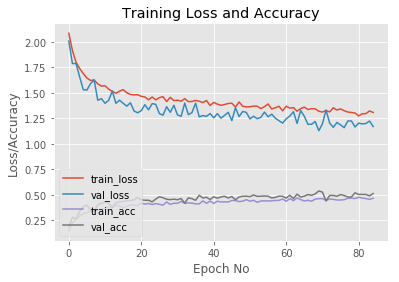

<Figure size 432x288 with 0 Axes>

In [24]:
plt.style.use("ggplot")
plt.figure()
N = 85
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch No")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_MobileNet_2.png')

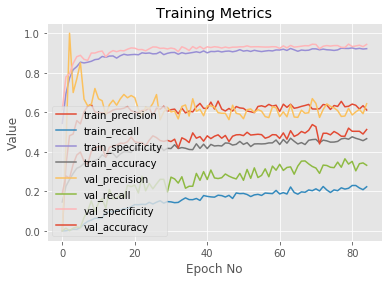

<Figure size 432x288 with 0 Axes>

In [23]:
plt.style.use("ggplot")
plt.figure()
N = 85
plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
plt.plot(np.arange(0, N), history.history["specificity"], label="train_specificity")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
plt.plot(np.arange(0, N), history.history["val_specificity"], label="val_specificity")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Metrics")
plt.xlabel("Epoch No")
plt.ylabel("Value")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_MobileNet_metrics_2.png')